In [1]:
# Analysis of loss of the Y chromosome in TCGA UVM 
# include NA cases in WT group (as before, by gene epression)
# 7-23-20
# Edited for revision of the manuscript: 11-1-2022
# Esther Rheinbay

import sys,os
import pandas as pd
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test
from lifelines import CoxPHFitter

from scipy.stats import ttest_ind, spearmanr, norm, mannwhitneyu, fisher_exact, chisquare
from statsmodels.stats.multitest import fdrcorrection
import matplotlib.pyplot as plt
import matplotlib

import seaborn as sns
import time
%matplotlib inline
plt.rcParams['pdf.fonttype'] = 42


In [2]:
# color palettes
palette = {'wt_male':'lightgrey', 'LOY':'cornflowerblue', 'wt_female':'lightgrey', 'LOX':'deeppink', 'NA':'white'}
Y_palette = {'wt':'lightgrey', 'LOY':'cornflowerblue', 'NA':'white'}
status_palette =  {'WT':'lightgrey', 'LOX':'mediumvioletred', 't0LOY':'darkslateblue', 'rLOY':'cornflowerblue', 'pLOY':'skyblue', 'pLOX':'mistyrose', 'Gain_Loss':'lightgoldenrodyellow', 'Gain':'lightcoral', 'LOY':'darkslateblue',}
Y_status_colors =  ['lightgrey', 'darkslateblue', 'cornflowerblue', 'skyblue', 'lightgoldenrodyellow', 'lightcoral']


In [3]:
fig_dir = ''

<h3> SEER incidence </h3>

Text(0.5, 1.0, 'SEER Eye and orbit cancer incidence in 2019')

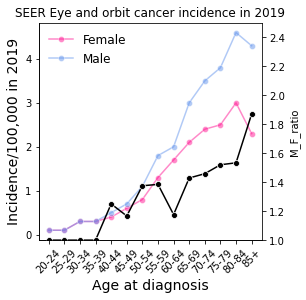

In [4]:
# SEER incidence in males and females in 2019
# from https://seer.cancer.gov/statistics-network/explorer/application.html?site=75&data_type=1&graph_type=2&compareBy=sex&chk_sex_3=3&chk_sex_2=2&hdn_rate_type=1&race=1&age_range=62&stage=101&advopt_precision=1&advopt_show_ci=on&advopt_display=1
seer_eye = pd.read_excel('SEER_eye_and_orbit_2019.xlsx', sheet_name=2, header = 0)
seer_eye_adult = seer_eye.iloc[5:19]

# Supplementary Figure 6B
fig, ax = plt.subplots(1, 1, figsize=(4, 4))
p= sns.lineplot(x = 'Age at Diagnosis', y = 'value', hue='variable',  data=pd.melt(seer_eye_adult, 'Age at Diagnosis' ), marker='o', palette=['deeppink','cornflowerblue' ], legend=False, alpha = 0.5)
plt.legend(title='', loc='upper left', labels=['Female', 'Male'], frameon=False, fontsize=12)
ax.set_ylabel('Incidence/100,000 in 2019', fontsize=14)
ax.set_xlabel('Age at diagnosis', fontsize=14)
ax.set_xticklabels(seer_eye_adult['Age at Diagnosis'], rotation=45)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
seer_eye_adult['M_F_ratio'] = seer_eye_adult.Male/seer_eye_adult.Female
ax2 = plt.twinx()
p= sns.lineplot(x = 'Age at Diagnosis', y = 'M_F_ratio', data=seer_eye_adult, marker='o', color = 'black', legend=False, ax=ax2)
ax2.set_ylim(1,2.5)
ax.set_title('SEER Eye and orbit cancer incidence in 2019')
plt.savefig(fig_dir + "SEER_incidence.pdf")

<h3> Load TCGA Y status calls and other data files </h3>

In [5]:
# General sample info from https://gdc.cancer.gov/about-data/publications/pancanatlas
TCGA_sample_info = pd.read_excel('TCGA-CDR-SupplementalTableS1.xlsx', sheet_name=0,  header=0, index_col=1)
males = TCGA_sample_info[TCGA_sample_info.gender=='MALE'].index.values
females = TCGA_sample_info[TCGA_sample_info.gender=='FEMALE'].index.values
TCGA_survival = pd.read_excel('TCGA/PANCAN_ATLAS/TCGA-CDR-SupplementalTableS1.xlsx', sheet_name="ExtraEndpoints", index_col=1)

# TCGA sample type codes from https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
TCGA_sample_type_codes = {'01': 'TP', '02':'TR', '03':'TB', '04':'TRBM', '05':'TAP', '06':'TM', '07':'TAM', '08':'THOC', '09':'TBM', '10':'NB', '11':'NT', '12':'NBC', '13':'NEBV', '14':'NBM', '15':'15SH', '16':'16SH', '20':'CELLC', '40':'TRB', '50':'CELL', '60':'XP', '61':'XCL', '99':'99SH'}


In [6]:
# chrY genes
chrY_genes =pd.read_csv('chrY.noPARgenes.txt', sep='\t', header=None, squeeze=True)
par_genes =pd.read_csv('chrY.PARgenes_6-22.txt', sep='\t', header=None, squeeze=True)


In [7]:
# 7 gene signature for assessing chrY expression
expressed_Y_genes = ['RPS4Y1', 'DDX3Y', 'ZFY','KDM5D', 'UTY', 'EIF1AY' , 'USP9Y' ]

In [8]:
# Detailed UVM data from supplementary table of the marker paper
UVM_clinical = pd.read_excel('TCGA_UVM_TableS1.xlsx', header=0, index_col=0,  sheet_name="Summary_by_Case", skiprows=[0,2,3])
UVM_subtypes = pd.read_excel('TCGA_UVM_TableS1.xlsx',  header=1, index_col=0,  sheet_name="Molecular-Clinical_Data")


In [9]:
# Load exome-based sex chromosome status
WEX_calls = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_1', header=0, index_col=0)

LOY_cases = WEX_calls[(WEX_calls.Gender=='male') & (WEX_calls.Y_status=='LOY')].index
wtY_cases = WEX_calls[(WEX_calls.Gender=='male') & (WEX_calls.Y_status=='WT')].index

TCGA_sample_info['LOY_status'] = TCGA_sample_info.apply(lambda x: WEX_calls.loc[x.name].Y_status if x.name in WEX_calls.index else np.nan, axis=1)

In [10]:
# One case has Y gain by WEX, here considered "wt" with respect to LOY
UVM_clinical['Y_status'] = UVM_clinical.apply(lambda x: 'LOY' if (x.name in males and x.name in LOY_cases) else ('wt_male' if x.name in males else 'NA'), axis=1)
UVM_subtypes['Y_status'] = UVM_subtypes.apply(lambda x: 'LOY' if (x.name in males and x.name in LOY_cases) else ('wt_male' if x.name in males else 'NA'), axis=1)


<h3> Association with age of diagnosis </h3>

Median LOY age at diagnosis: 68.0
Median wt age at diagnosis: 58.0


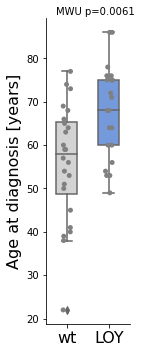

In [11]:
# Figure 5B
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'Y_status', y = 'Age at Diagnosis' , data=UVM_clinical[UVM_clinical.Gender=='Male'], orient='v', width=0.5, palette=palette, order = ['wt_male', 'LOY'])
sns.stripplot(x = 'Y_status', y = 'Age at Diagnosis' , data=UVM_clinical[UVM_clinical.Gender=='Male'], color = 'grey', order = ['wt_male', 'LOY'])
ax.set_xlabel('sex chromosome _status')
ax.text(x= -0.25, y=90, s='MWU p=' + str(round(mannwhitneyu(UVM_clinical[UVM_clinical.Y_status=='LOY']['Age at Diagnosis'], UVM_clinical[UVM_clinical.Y_status=='wt_male']['Age at Diagnosis']).pvalue,4)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlabel('')
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
ax.set_ylabel('Age at diagnosis [years]', fontsize=16)
print('Median LOY age at diagnosis:', round(np.nanmedian(UVM_clinical[UVM_clinical.Y_status=='LOY']['Age at Diagnosis']),0))
print('Median wt age at diagnosis:', round(np.nanmedian(UVM_clinical[UVM_clinical.Y_status=='wt_male']['Age at Diagnosis']),0))
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_age_at_diagnosis_boxplot.pdf')


In [12]:
# IQR for age difference between LOY and wt
print("LOY:", UVM_subtypes[UVM_subtypes.Y_status=='LOY']['Age at Diagnosis'].describe())
print("wt:", UVM_subtypes[UVM_subtypes.Y_status=='wt_male']['Age at Diagnosis'].describe())

LOY: count    21.000000
mean     67.571429
std      10.851596
min      49.000000
25%      60.000000
50%      68.000000
75%      75.000000
max      86.000000
Name: Age at Diagnosis, dtype: float64
wt: count    24.000000
mean     55.958333
std      13.417961
min      22.000000
25%      48.750000
50%      58.000000
75%      65.250000
max      77.000000
Name: Age at Diagnosis, dtype: float64


<h3> Association with distant metastasis</h3>

Distant Metastasis  No  Yes
Y_status                   
LOY                 10   11
wt_male             19    5
LOY/metastasis Fisher p: (0.23923444976076555, 0.034518151920673264)
52.38095238095239 % of LOY cases metastasized vs 20.833333333333336 % of wt cases


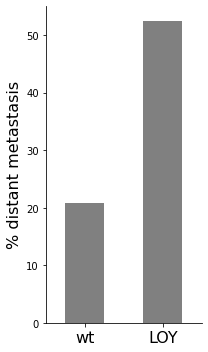

In [13]:
# Figure 5C
df = UVM_clinical[UVM_clinical.Gender=='Male'].groupby('Y_status')['Distant Metastasis'].value_counts().unstack().loc[['LOY', 'wt_male']]
print(df)
met_fisher = fisher_exact(df)
print('LOY/metastasis Fisher p:', met_fisher)
print(11/21*100, '% of LOY cases metastasized vs', 5/24*100, '% of wt cases' )
df.fraction = df.Yes/(df.Yes+df.No)*100
plt.figure(figsize=(3,5)) 
df.fraction[['wt_male', 'LOY']].plot(kind='bar', color='grey')
plt.gca().spines['right'].set_visible(False)
#plt.legend(loc='upper right', bbox_to_anchor=(1.4, 1.0), frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% distant metastasis', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('')
plt.xticks([0,1], labels=['wt', 'LOY'], rotation = 0, fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_distant_met_barplot.pdf')

<h3> Independent validation data from Laurent et al, 2011 (PMID: 21135111) </h3>

In [14]:
# Affy arrays for 63 patients (39 male, female), GEO Accession: GSE22138
# the GEO series matrix file contains age, sex and survival information
Laurent_meta_data = pd.read_csv('GSE22138_series_matrix.txt', sep='\t', skiprows=46, index_col=0, skipfooter= 54764-67).transpose()

In [15]:
cols = Laurent_meta_data.iloc[0,Laurent_meta_data.columns.values=="!Sample_characteristics_ch1"]
colnames = list(map(lambda x: x.split(':')[0], cols))

Laurent_meta_data.columns.values[Laurent_meta_data.columns.values=="!Sample_characteristics_ch1"]=colnames
for c in colnames:

    Laurent_meta_data[c]= Laurent_meta_data.apply(lambda x: x[c].split(':')[1].strip(), axis=1)

# Inspect data frame
Laurent_meta_data.head()

!Sample_geo_accession,!Sample_status,!Sample_submission_date,!Sample_last_update_date,!Sample_type,!Sample_channel_count,!Sample_source_name_ch1,!Sample_organism_ch1,tissue,age,gender,eye,tumor location,tumor diameter (mm),tumor thickness (mm),tumor cell type,retinal detachment,extrascleral extension,chromosome 3 status,months to endpoint,metastasis
GSM550623,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),76.54,female,right,NA,NA,12.2,mixed,no,NA,NA,73,no
GSM550624,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),67.57,male,left,on equator,10,11.3,epithelioid,NA,NA,NA,32.13,yes
GSM550625,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),61.82,male,right,on equator,20,10.9,NA,yes,NA,NA,0.39,yes
GSM550626,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),46.4,male,right,posterior to equator,15,14,mixed,yes,yes,disomy,64,yes
GSM550627,Public on Dec 14 2010,Jun 04 2010,Dec 14 2010,RNA,1,Eye,Homo sapiens,Uveal Melanoma (eye),84.99,male,right,anterior to equator,20,7,NA,no,NA,monosomy,67.81,no


In [16]:
# list of housekeeping genes to normalize Y expression to total expression (does not contain Y genes)
housekeeping = pd.read_csv('tirosh_house_keeping.txt', sep='\t', header=None, skiprows=2)
housekeeping.columns = ['gene']

# replace HPRT with HPRT1, its human gene name
housekeeping[housekeeping.gene=='HPRT']='HPRT1'

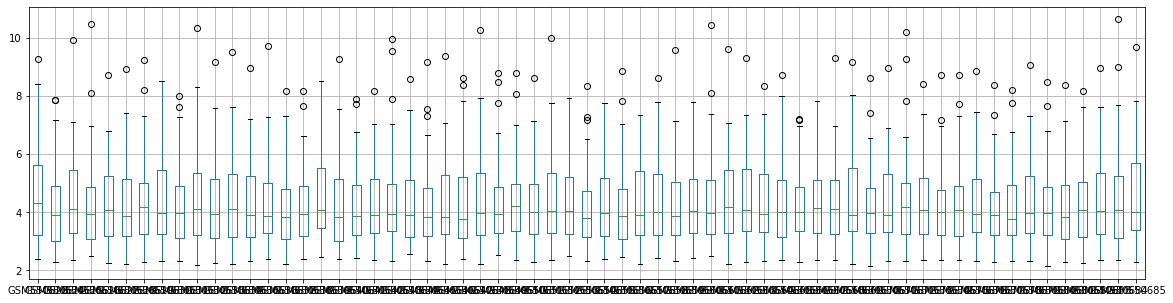

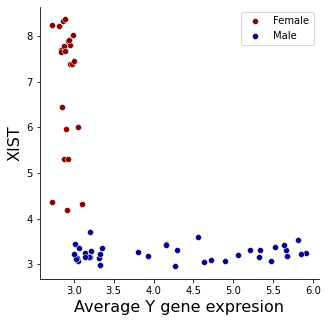

In [17]:
# chrY gene expression signatures for Laurent dataset
Laurent_exp = pd.read_csv(workdir + 'GSE22138_RAW/data.ann.txt', sep='\t', index_col=0, header=0)
Laurent_exp.columns.values[4:67] = list(map(lambda x: x.split(".")[0], Laurent_exp.columns.values[4:67]))

# remove cross-mapping probes ("_x_at")
Laurent_exp=Laurent_exp[~Laurent_exp["Row.names"].str.endswith("_x_at")]

# More or less normalized? Check distributions
fig, ax = plt.subplots(1, 1, figsize=(20, 5))
Laurent_exp[4:67].boxplot()

# calculate average Y score
Laurent_avg_Y = Laurent_exp[Laurent_exp.SYMBOL.isin(expressed_Y_genes)][Laurent_exp.columns.values[4:67]].apply(lambda x: np.nanmean(x), axis=0)
Laurent_meta_data['avg_Y_exp'] = Laurent_meta_data.apply(lambda x: Laurent_avg_Y[x.name], axis=1)

# housekeeping normalization 
Laurent_avg_housekeeping_tumor = Laurent_exp[Laurent_exp.SYMBOL.isin(housekeeping.gene)][Laurent_exp.columns.values[4:67]].apply(lambda x: np.nanmean(x), axis=0)
Laurent_ratio_Y_housekeeping_tumor = Laurent_avg_Y/Laurent_avg_housekeeping_tumor
Laurent_meta_data['ratio_Y_housekeeping_tumor'] = Laurent_meta_data.apply(lambda x: Laurent_ratio_Y_housekeeping_tumor[x.name], axis=1)
Laurent_meta_data["Y_status"] = Laurent_meta_data.apply(lambda x: 'fLOY' if x.ratio_Y_housekeeping_tumor<0.5 else 'wt_male', axis=1)
# add XIST expression
Laurent_XIST = Laurent_exp[Laurent_exp.SYMBOL=="XIST"][Laurent_exp.columns.values[4:67]].apply(lambda x: np.nanmean(x), axis=0)
Laurent_meta_data['XIST'] = Laurent_meta_data.apply(lambda x: Laurent_XIST[x.name], axis=1)

# check chrY average expression vs XIST
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.scatterplot(x = "avg_Y_exp", y = "XIST", data = Laurent_meta_data[Laurent_meta_data.gender=='female'], color='darkred', ax=ax)
sns.scatterplot(x = "avg_Y_exp", y = "XIST", data = Laurent_meta_data[Laurent_meta_data.gender=='male'], color='darkblue', ax=ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_ylabel('XIST', fontsize=16)
ax.set_xlabel('Average Y gene expresion', fontsize=16)
ax.legend(['Female', 'Male'])


wt_male    20
fLOY       19
Name: Y_status, dtype: int64
Fraction of male samples with LOY: 0.48717948717948717


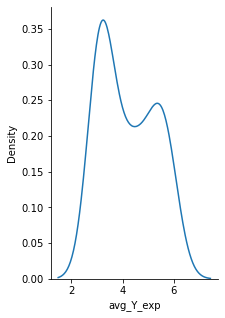

In [18]:
# Supplementary Figure 5A
# Classify male patients into fLOY and with Y based on above plot (fLOY cutoff <3.5)
Laurent_males = Laurent_meta_data[Laurent_meta_data.gender=='male']
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
sns.distplot(Laurent_males.avg_Y_exp, hist=False)
ax.set_ylabel('Density')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.savefig(fig_dir + 'Laurent_chrY_dist.pdf')
Laurent_males["Y_status"] = Laurent_males.apply(lambda x: 'fLOY' if x.avg_Y_exp<4 else 'wt_male', axis=1)
print(Laurent_males.Y_status.value_counts())
print ('Fraction of male samples with LOY:',float(Laurent_males.Y_status.value_counts()['fLOY'])/float(Laurent_males.shape[0]))

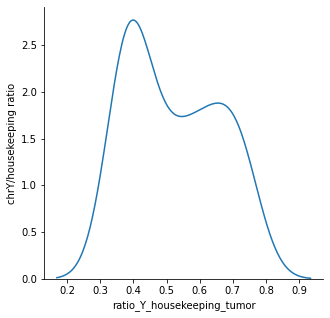

In [19]:
# Classify male patients into fLOY and with Y based on above plot, using Y/housekeeping ratio. Same results.
Laurent_males = Laurent_meta_data[Laurent_meta_data.gender=='male']
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
sns.distplot(Laurent_males.ratio_Y_housekeeping_tumor, hist=False)
ax.set_ylabel('chrY/housekeeping ratio')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

Laurent_males["Y_status"] = Laurent_males.apply(lambda x: 'fLOY' if x.ratio_Y_housekeeping_tumor<0.5 else 'wt_male', axis=1)


49% of males in Laurent cohort have LOY, consistent with 47% in TCGA UVM. 

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
             alpha = 0.99
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           4.00 0.05      4.46

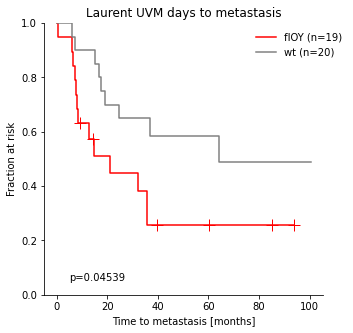

In [20]:
# Figure 5B
# endpoint is metastasis-free survival
MFS_time = Laurent_males['months to endpoint']
metastasis = Laurent_males['metastasis']
metastasis = metastasis.apply(lambda x: 1 if x=='yes' else 0)

# Split (male) patients into low_Y and other
Laurent_low_Y = Laurent_males[Laurent_males.Y_status=='fLOY'].index.values
Laurent_other = Laurent_males[Laurent_males.Y_status=='wt_male'].index.values

# Kaplan-Meier analysis
kmf = KaplanMeierFitter() 
fig, ax = plt.subplots(1,1, figsize=(5,5))
k1 = kmf.fit(MFS_time[Laurent_low_Y], metastasis[Laurent_low_Y],label='flOY (n=' + str(len(Laurent_low_Y)) + ')' )
ax = k1.plot(ci_show=False, color="red" , show_censors=True) 
ax.set_ylabel('Fraction at risk')

k2 = kmf.fit(MFS_time[Laurent_other].dropna(), metastasis[Laurent_other].dropna(),label='wt (n=' + str(len(Laurent_other)) + ')' )
k2.plot(ax=ax, color='grey', ci_show=False)
test = logrank_test(MFS_time[Laurent_low_Y].astype(float), MFS_time[Laurent_other].astype(float), metastasis[Laurent_low_Y], metastasis[Laurent_other], alpha=.99)
test.print_summary()
ax.set_ylim([0,1])
ax.text(5, 0.05, "p=" + str(round(test.p_value,5)))
ax.set_xlabel('Time to metastasis [months]')
ax.set_title('Laurent UVM days to metastasis')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(loc='upper right', bbox_to_anchor=(1.1, 1.0), frameon=False)
plt.savefig(fig_dir + 'Laurent_KM_males.pdf')

In [21]:
# Does the association of LOY with age at diagnosis hold?
Laurent_males['age'] = pd.to_numeric(Laurent_males['age'])
print('Median LOY age at diagnosis:', round(np.nanmedian(Laurent_males[Laurent_males.Y_status=='fLOY']['age']),0))
print('Median wt age at diagnosis:', round(np.nanmedian(Laurent_males[Laurent_males.Y_status=='wt_male']['age']),0))

Median LOY age at diagnosis: 68.0
Median wt age at diagnosis: 60.0


metastasis  no  yes
Y_status           
fLOY         6   13
wt_male     11    9
68.42105263157895 % of fLOY cases metastasized vs 45.0 % of wt cases


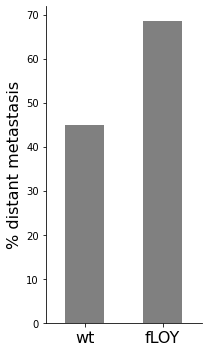

In [22]:
# Supplementary Figure 7B - association of LOY with metastasis
df = Laurent_males.groupby('Y_status').metastasis.value_counts().unstack()
Laurent_metastasis_status = Laurent_males.metastasis
Laurent_met_fisher = fisher_exact(df)
print(df)
print(13/19*100, '% of fLOY cases metastasized vs', 9/20*100, '% of wt cases')

met_fisher = fisher_exact(df)
df.fraction = df.yes/(df.yes+df.no)*100
plt.figure(figsize=(3,5)) 
df.fraction[['wt_male', 'fLOY']].plot(kind='bar', color='grey')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% distant metastasis', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('')
plt.xticks([0,1], labels=['wt', 'fLOY'], rotation = 0, fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_Laurent_distant_met_barplot.pdf')

<h3> EMT and subclonal fraction </h3>

In [23]:
# EMT scores from Gibbons & Creighton, 2016, PMID: 28073171
# Higher score = more EMT (scores is the sum of mesenchymal markers- epithelial markers)
EMT_scores = pd.read_excel('NIHMS840944-supplement-Supp_Datafile_S1.xlsx', sheet_name=0, skiprows=2, header=0, index_col=1)
EMT_scores['sample_id'] = EMT_scores.apply(lambda x: x.name[0:12], axis=1)
EMT_scores['LOY_status'] = EMT_scores.apply(lambda x: TCGA_sample_info.loc[x.sample_id].LOY_status if x.sample_id in TCGA_sample_info.index else 'NA', axis=1)
EMT_scores['gender'] = EMT_scores.apply(lambda x: TCGA_sample_info.loc[x.sample_id].gender if x.sample_id in TCGA_sample_info.index else 'NA', axis=1)

[Text(0, 0, 'wt'), Text(1, 0, 'LOY')]

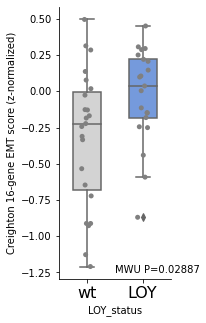

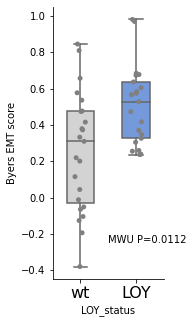

In [24]:
# Figure 5D
# EMT scores for males only
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'LOY_status', y = 'Creighton 16-gene EMT score (z-normalized)', data = EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], order = ['WT', 'LOY'], palette=['lightgrey', 'cornflowerblue'], width=0.5) 
sns.stripplot(x = 'LOY_status', y = 'Creighton 16-gene EMT score (z-normalized)' , data=EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], color = 'grey', order = ['WT', 'LOY'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
ax.text(0.5, -1.25, 'MWU P=' + str(round(mannwhitneyu(EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='WT')]['Creighton 16-gene EMT score (z-normalized)'], EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='LOY')]['Creighton 16-gene EMT score (z-normalized)'])[1],5)))
#plt.savefig(fig_dir + 'UVM_EMT_Creighton.pdf')

# Byers score 
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'LOY_status', y = 'Byers EMT score (z-normalized)', data = EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], order = ['WT', 'LOY'], palette=['lightgrey', 'cornflowerblue'], width=0.5) 
sns.stripplot(x = 'LOY_status', y = 'Byers EMT score (z-normalized)' , data=EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM')], color = 'grey', order = ['WT', 'LOY'])
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.text(0.5, -.25, 'MWU P=' + str(round(mannwhitneyu(EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='WT')]['Byers EMT score (z-normalized)'], EMT_scores[(EMT_scores.gender=='MALE') & (EMT_scores['cancer type']=='UVM') & (EMT_scores.LOY_status=='LOY')]['Byers EMT score (z-normalized)'])[1],4)))
ax.set_ylabel('Byers EMT score')
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
#plt.savefig(fig_dir + 'UVM_EMT_Byers.pdf')

Text(0, 0.5, 'Subclonal genome fraction')

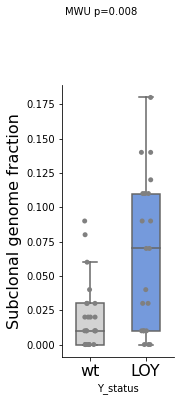

In [25]:
# Figure 5E
# subclonal genome fraction
fig, ax = plt.subplots(1, 1, figsize=(2, 5))
sns.boxplot(x = 'Y_status', y = 'Subclonal genome fraction'  , data=UVM_subtypes, orient='v', order=[ "wt_male", "LOY"], width=0.5, palette=palette, fliersize=0)
sns.stripplot(x = 'Y_status', y = 'Subclonal genome fraction'  , data=UVM_subtypes, orient='v', order=[ "wt_male", "LOY"], color='grey')
ax.text(x=-0.45, y=0.24, s='MWU p=' + str(round(mannwhitneyu(UVM_subtypes[UVM_subtypes.Y_status=='LOY']['Subclonal genome fraction' ], UVM_subtypes[UVM_subtypes.Y_status=='wt_male']['Subclonal genome fraction' ]).pvalue,3)))
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xticklabels(['wt', 'LOY'], fontsize=16)
ax.set_ylabel('Subclonal genome fraction', fontsize=16)
plt.savefig(fig_dir + 'UVM_subclonal_genome_fraction_boxplot.pdf')

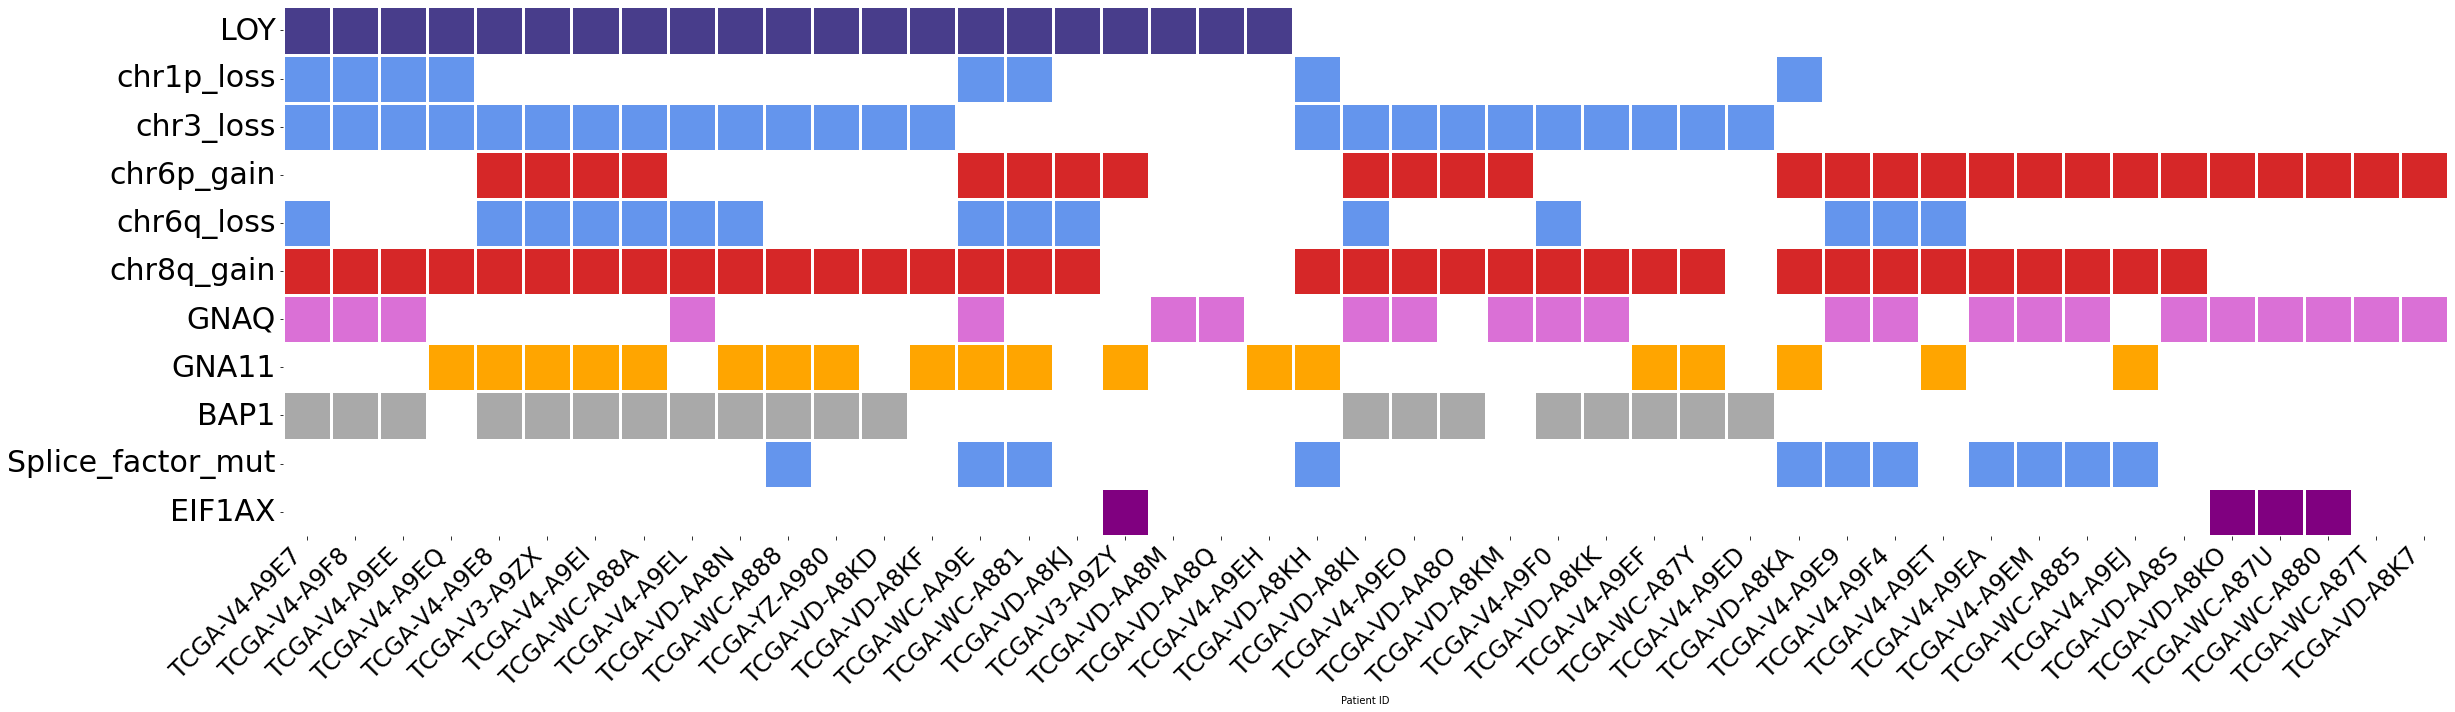

In [26]:
# Figure 5F
# "comut" plot with TCGA alterations and LOY
# SF3B1, SRSF2 (combined as splice factors)

# copy number changes associated with UVM
#losses in 1p, 6q, 8p; gains in 6p and 8q; and chromosome 3 loss/monosomy 3 (loss of both 3p and 3q)

# code losses from supplementary table
# cut off trailing text ('partial', 'no LOH')
UVM_subtypes['chr1p_loss'] = UVM_subtypes.apply(lambda x: 1 if int(str(x['1p copy number (ABSOLUTE)']).split(' ')[0])<2 else 0, axis=1)
UVM_subtypes['chr6q_loss'] = UVM_subtypes.apply(lambda x: 1 if (x['6q CN (ABSOLUTE)']=='chromothripsis' or int(str(x['6q CN (ABSOLUTE)']).split(' ')[0])<2) else 0, axis=1)

# code gains from supplementary table
UVM_subtypes['chr6p_gain'] = UVM_subtypes.apply(lambda x: 5 if (int(str(x['6p copy number (ABSOLUTE)']).split(' ')[0]) >2) else 0, axis=1)
UVM_subtypes['chr8q_gain'] = UVM_subtypes.apply(lambda x: 5 if (int(str(x['8q CN (ABSOLUTE)'])) >2) else 0, axis=1)

# monosomy 3 - this includes 2 copies with LOH
UVM_subtypes['chr3_loss'] = UVM_subtypes.apply(lambda x: 1 if (re.search('LOH', str(x['3 CN (ABSOLUTE)'])) or int(x['3 CN (ABSOLUTE)']) <2) else 0, axis=1)

# code mutations
UVM_subtypes['Splice_factor_mut'] = UVM_subtypes.apply(lambda x: 0 if (pd.isnull(x.SF3B1) & pd.isnull(x.SRSF2)) else 1, axis=1)
UVM_subtypes['BAP1_coded'] = UVM_subtypes.apply(lambda x: 0 if (pd.isnull(x.BAP1)) else 1, axis=1)


comut_data = UVM_subtypes
comut_data_males = comut_data[comut_data.Gender=='Male']

comut_binned = comut_data_males[['EIF1AX', 'Y_status','chr1p_loss', 'chr3_loss', 'chr6p_gain', 'chr6q_loss', 'chr8q_gain', 'GNAQ' ,'GNA11' ,'BAP1', 'Splice_factor_mut']]

# code mutations
comut_binned['EIF1AX'] = comut_binned.apply(lambda x: 0 if pd.isnull(x['EIF1AX']) else 4, axis=1)
comut_binned['BAP1'] = comut_binned.apply(lambda x: 0 if pd.isnull(x['BAP1']) else 6, axis=1)
comut_binned['GNAQ'] = comut_binned.apply(lambda x: 0 if pd.isnull(x.GNAQ) else 7, axis=1)
comut_binned['GNA11'] = comut_binned.apply(lambda x: 0 if pd.isnull(x.GNA11) else 8, axis=1)
comut_binned['LOY'] = comut_binned.apply(lambda x: 2 if x.Y_status=='LOY' else 0, axis=1)
comut_binned.sort_values(by=['LOY', 'chr3_loss','chr1p_loss',  'chr8q_gain','chr6p_gain', 'chr6q_loss',   'BAP1', 'Splice_factor_mut', 'EIF1AX',  'GNAQ', 'GNA11'], inplace=True, ascending=False)


fig, ax = plt.subplots(figsize=(40, 10))
sns.heatmap(comut_binned[['LOY', 'chr1p_loss', 'chr3_loss',  'chr6p_gain', 'chr6q_loss', 'chr8q_gain', 'GNAQ', 'GNA11', 'BAP1', 'Splice_factor_mut',  'EIF1AX']].transpose(), cmap=matplotlib.colors.ListedColormap(['white', 'cornflowerblue', 'darkslateblue', 'deeppink' , 'purple', 'tab:red', 'darkgrey', 'orchid', 'orange', 'green']), linewidths=2.5, square=True, annot_kws={"size": 10}, vmin=0, vmax=10, cbar=False)
ax.set_xticklabels(ax.get_xmajorticklabels(), fontsize = 24, rotation=45, ha='right')
ax.set_yticklabels(ax.get_ymajorticklabels(), fontsize = 30, rotation=0, ha='right')
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_comut.pdf')



In [27]:
# Associations with alterations in comut plot (too few to necessitate FDR correction)
# two-sided test to evaluate enrichment and depletion

for event in ['chr1p_loss', 'chr3_loss',  'chr6p_gain', 'chr6q_loss', 'chr8q_gain', 'GNAQ', 'GNA11', 'BAP1', 'Splice_factor_mut',  'EIF1AX']:
    df = comut_binned[['Y_status',event]].value_counts()
    print('Fisher odds and p for LOY/wt_male and ' + event + ':', str(round(fisher_exact(df.unstack().loc[['wt_male', 'LOY', ]])[0],2)),',',  fisher_exact(df.unstack().loc[['wt_male', 'LOY', ]])[1])



Fisher odds and p for LOY/wt_male and chr1p_loss: 4.4 , 0.12050263973122756
Fisher odds and p for LOY/wt_male and chr3_loss: 2.8 , 0.13630599064834004
Fisher odds and p for LOY/wt_male and chr6p_gain: 0.21 , 0.017154926333019755
Fisher odds and p for LOY/wt_male and chr6q_loss: 3.45 , 0.11162653880345508
Fisher odds and p for LOY/wt_male and chr8q_gain: 1.42 , 0.728883034611907
Fisher odds and p for LOY/wt_male and GNAQ: 0.25 , 0.03768203914316956
Fisher odds and p for LOY/wt_male and GNA11: 4.88 , 0.01715492633301975
Fisher odds and p for LOY/wt_male and BAP1: 2.67 , 0.13966340176340958
Fisher odds and p for LOY/wt_male and Splice_factor_mut: 0.33 , 0.17715621289075587
Fisher odds and p for LOY/wt_male and EIF1AX: 0.35 , 0.6109936575052863


In [28]:
# in official UVM MAF from TCGA UVM paper, TCGA-V4-A9EA has a DDX3Y missense mutation; this one is a wt sample

<h3> Survival analysis including other predictors </h3>

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,z,p,-log2(p)
covariate,,,,,,,,,,
Age at Diagnosis,0.012907,1.012991,0.028561,-0.043072,0.068885,0.957843,1.071313,0.451906,0.651337,0.618524
chr3_loss,2.496408,12.138817,1.043819,0.450560,4.542257,1.569191,93.902464,2.391610,0.016775,5.897572
chr8q_gain,-0.062716,0.939210,0.270420,-0.592729,0.467296,0.552817,1.595674,-0.231923,0.816598,0.292302
chr6q_loss,1.220545,3.389036,0.780063,-0.308350,2.749441,0.734658,15.633892,1.564675,0.117659,3.087315
chr6p_gain,-0.013906,0.986190,0.145173,-0.298440,0.270628,0.741975,1.310787,-0.095790,0.923688,0.114523
Y_status,1.356513,3.882633,0.625073,0.131392,2.581635,1.140415,13.218732,2.170166,0.029994,5.059171
Splice_factor_mut,-0.157891,0.853943,0.891150,-1.904513,1.588731,0.148895,4.897528,-0.177177,0.859369,0.218650


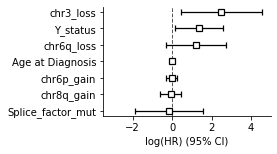

In [29]:
# Figure 5G
# More predictors included per reviewer's request
# cox regression for LOY and other known predictors of expression in UVM
cph = CoxPHFitter()

# do not include EIF1AX or 6q loss due to low counts (<10)
covariates = ['Age at Diagnosis','chr3_loss', 'chr8q_gain',  'chr1p_loss', 'chr6q_loss', 'chr6p_gain',  'Y_status', 'Splice_factor_mut']
cph_pfs_males = UVM_subtypes.loc[[x for x in UVM_subtypes.index.values if x in males]]
cph_pfs_males['Y_status'] = cph_pfs_males.apply(lambda x: 1 if x.name in LOY_cases else 0, axis=1)
cph_pfs_males['PFS.time'] = cph_pfs_males.apply(lambda x: TCGA_survival.loc[x.name]['PFS.time'], axis=1)
cph_pfs_males['PFS_status'] = cph_pfs_males.apply(lambda x: TCGA_survival.loc[x.name]['PFS'], axis=1)
    
cph_pfs = cph_pfs_males[['Age at Diagnosis','chr3_loss', 'chr8q_gain', 'chr6q_loss', 'chr6p_gain',   'Y_status' , 'Splice_factor_mut', 'PFS_status', 'PFS.time']]
cph.fit(cph_pfs.dropna(), duration_col='PFS.time', event_col='PFS_status')
fig, ax = plt.subplots(1,1, figsize = (3,2))
cph.plot(hazard_ratios=False, ax = ax)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.set_xlim(-3.5, 5)
plt.savefig(fig_dir + "UVM_Cox_revision.pdf")
cph.summary.to_csv(fig_dir + 'UVM_Cox_revision_table.txt', sep='\t', index=True)
cph.summary


<h2> Differential gene expression between LOY and wt UVM cases <h2>

In [30]:
# TCGA pancan expression data
# gene expression from pancan atlas: http://api.gdc.cancer.gov/data/3586c0da-64d0-4b74-a449-5ff4d9136611
TCGA_pancan_exp = pd.read_csv('EBPlusPlusAdjustPANCAN_IlluminaHiSeq_RNASeqV2.geneExp.tsv', sep='\t', header=0, index_col=0)

# sample codes from code table https://gdc.cancer.gov/resources-tcga-users/tcga-code-tables/sample-type-codes
tumor_codes = ['01', '02', '03', '04', '04', '06', '07', '08', '09']
normal_codes = ['10', '11', '12', '13', '14']


# divide samples into tumors and normals (-01*- are tumor samples; -06A- is a metastatic sample); most normals have code -11A-
stype = ['tumor' if x.split('-')[3][0:2] in tumor_codes else 'normal' if x.split('-')[3][0:2] in normal_codes else 'NA' for x in TCGA_pancan_exp.columns.values]

#stype = ['tumor' if ('-01A-' in x or '-01B-' in x or '-01C-' in x or '-06A-' in x) else 'normal' for x in TCGA_pancan_exp.columns.values]
sample_type = pd.Series(stype, index = TCGA_pancan_exp.columns.values)

#change index to gene names only
TCGA_pancan_exp.index = map(lambda x: x.split('|')[0], TCGA_pancan_exp.index.values)

# extract tumors only
tumor_exp = TCGA_pancan_exp[sample_type[sample_type=='tumor'].index.values]

# extract normal samples only
normal_exp = TCGA_pancan_exp[sample_type[sample_type=='normal'].index.values]

# shorten column names/patient IDs
tumor_exp.rename(columns = lambda x: x[0:12], inplace=True)
normal_exp.rename(columns = lambda x: x[0:12], inplace=True)

# remove duplicate gene expression data for the same sample
tumor_exp_unique = tumor_exp.iloc[:, ~tumor_exp.columns.duplicated()]
normal_exp_unique = normal_exp.iloc[:, ~normal_exp.columns.duplicated()]


In [31]:
# Subset to males and females
common_males = list(set(tumor_exp_unique.columns.values).intersection(set(males)))
common_females = list(set(tumor_exp_unique.columns.values).intersection(set(females)))
tumor_exp_unique_males = tumor_exp_unique[common_males]
tumor_exp_unique_females = tumor_exp_unique[common_females]

In [32]:
# Differential gene expression between lowY and other samples in UVM

UVM_exp= tumor_exp_unique[[x for x in UVM_clinical.index if x in tumor_exp_unique.columns]]
UVM_exp_males = UVM_exp[[x for x in UVM_exp.columns if x in UVM_clinical[UVM_clinical.Gender=='Male'].index]]

UVM_diff_exp_pvalues = pd.DataFrame(index = UVM_exp_males.index.values, columns = ['ttest_p_LOY', 'avg_LOY', 'avg_wtY'])
UVM_diff_exp_pvalues = UVM_diff_exp_pvalues.fillna(np.nan)

for g in UVM_exp.index.values:  
    if g =="?":
        continue
    g_LOY = UVM_exp.loc[g][set(LOY_cases) & set(UVM_exp.columns.values)].dropna()
    g_wtY = UVM_exp.loc[g][set(wtY_cases) & set(UVM_exp.columns.values)].dropna()

    if len(g_LOY)<=3 or len(g_wtY) <=3:
        continue

    UVM_diff_exp_pvalues.loc[g]['ttest_p_LOY'] = ttest_ind(g_LOY, g_wtY, equal_var=False, nan_policy='omit')[1]
    UVM_diff_exp_pvalues.loc[g]['avg_LOY'] = np.nanmean(g_LOY)
    UVM_diff_exp_pvalues.loc[g]['avg_wtY'] = np.nanmean(g_wtY)


In [33]:
# calculate some more values - LOY
UVM_diff_exp_pvalues = UVM_diff_exp_pvalues.dropna()

# add pseudocounts to fold diff calculation to avoid zero float division error
UVM_diff_exp_pvalues['fold_diff_LOY'] = UVM_diff_exp_pvalues.apply(lambda x: float(x.avg_LOY+0.01)/float(x.avg_wtY+0.01), axis=1) 
UVM_diff_exp_pvalues['log2_fold_diff_LOY'] = UVM_diff_exp_pvalues.apply(lambda x: np.log2(x.fold_diff_LOY), axis=1)

UVM_diff_exp_pvalues['q_value_LOY']=fdrcorrection(UVM_diff_exp_pvalues.ttest_p_LOY)[1]
UVM_diff_exp_pvalues.sort_values(by='q_value_LOY', inplace=True)
UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1]


,ttest_p_LOY,avg_LOY,avg_wtY,fold_diff_LOY,log2_fold_diff_LOY,q_value_LOY
KDM5D,5.969768e-14,55.668362,1072.069174,0.051935,-4.267151,1.153001e-09
RPS4Y1,1.118348e-12,224.992876,11917.663913,0.018880,-5.727015,1.079988e-08
SFRS17A,2.894298e-09,489.379429,887.321913,0.551529,-0.858491,1.863349e-05
UTY,4.345135e-09,12.920033,358.506087,0.036065,-4.793240,2.098049e-05
ZBED1,1.364432e-08,1216.922619,2158.044348,0.563903,-0.826482,5.189368e-05
DDX3Y,1.880790e-08,58.126881,908.849565,0.063967,-3.966532,5.189368e-05
TTTY15,1.642603e-08,8.106438,149.771752,0.054188,-4.205871,5.189368e-05
TTTY14,1.924871e-07,0.052871,11.902396,0.005278,-7.565843,4.647120e-04
EIF1AY,3.451548e-07,18.432490,486.150665,0.037935,-4.720328,7.407022e-04
TMSB4Y,5.627772e-07,2.132105,32.574448,0.065740,-3.927083,1.086948e-03


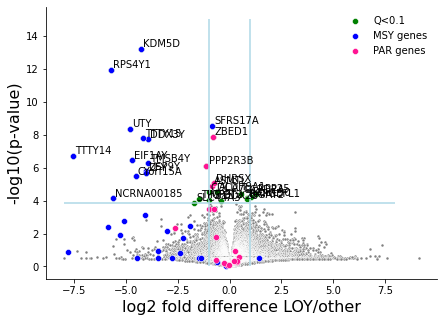

In [34]:
# Figure 5H
# volcano plot- log2FD vs log10 p-value
# only use genes that are in expression data
# CYorf15A is TXLNGY 
# is NCRNA00185 is TTTY14
exp_Y_genes = [x for x in chrY_genes if x in UVM_diff_exp_pvalues.index]+['CYorf15A', 'NCRNA00185', 'SFRS17A']
exp_par_genes = [x for x in par_genes if x in UVM_diff_exp_pvalues.index]
fig, ax = plt.subplots(1, 1, figsize=(7, 5))
sns.scatterplot(x = UVM_diff_exp_pvalues.log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues.ttest_p_LOY), color='grey', marker = '.', ax=ax)
sns.scatterplot(x = UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].ttest_p_LOY), color='green', label = 'Q<0.1')
sns.scatterplot(x = UVM_diff_exp_pvalues.loc[exp_Y_genes].log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues.loc[exp_Y_genes].ttest_p_LOY), marker = 'o', color='blue', label = 'MSY genes')
sns.scatterplot(x = UVM_diff_exp_pvalues.loc[exp_par_genes].log2_fold_diff_LOY, y = -np.log10(UVM_diff_exp_pvalues.loc[exp_par_genes].ttest_p_LOY), marker = 'o', color='deeppink', label = 'PAR genes')

# indicate significance threshold
ax.hlines(-np.log10(np.max(UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].ttest_p_LOY)), -8,8, color = 'lightblue')
# lines for 2-fold up or down
ax.vlines(-np.log2(2), 0,15, color = 'lightblue')
ax.vlines(np.log2(2), 0,15, color = 'lightblue')
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
for index, row in UVM_diff_exp_pvalues[UVM_diff_exp_pvalues.q_value_LOY<0.1].iterrows():
    ax.text(row.log2_fold_diff_LOY+0.1, -np.log10(row.ttest_p_LOY)+0.1, row.name)
ax.legend(loc='upper right', frameon=False)
ax.set_ylabel('-log10(p-value)', fontsize=16)
ax.set_xlabel('log2 fold difference LOY/other', fontsize=16)
plt.savefig(fig_dir + "TCGA_UVM_DE_volcano.pdf")
plt.savefig(fig_dir + "TCGA_UVM_DE_volcano.png")

In [35]:
UVM_diff_exp_pvalues.to_csv('/Users/esther/Documents/Projects/2019/chrY/Manuscript/UVM_diff_exp.tsv',sep='\t', header=True, index = True)

Text(0, 0.5, 'UTY expression (RSEM)')

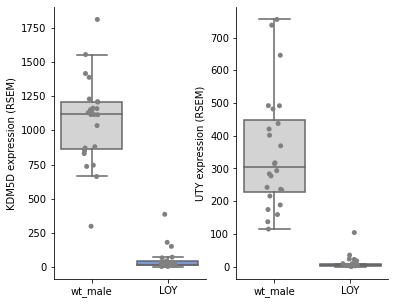

In [36]:
# Supplementary Figure 7D
g = 'KDM5D'
g_LOY = UVM_exp.loc[g][set(LOY_cases) & set(UVM_exp.columns.values)].dropna()
g_wtY = UVM_exp.loc[g][set(wtY_cases) & set(UVM_exp.columns.values)].dropna()

df = pd.DataFrame(UVM_exp_males.loc[g].transpose())
df['Y_status'] = df.apply(lambda x: UVM_subtypes.loc[x.name].Y_status, axis=1)

fig, ax = plt.subplots(1,2, figsize = (6,5))
sns.boxplot(x = 'Y_status', y = g, data = df, palette = ['lightgrey', 'cornflowerblue'], order=['wt_male', 'LOY'] ,ax=ax[0], fliersize=0)
sns.stripplot(x = 'Y_status', y = g, data = df, order=['wt_male', 'LOY'], color='grey', ax=ax[0])
ax[0].spines['right'].set_visible(False)
ax[0].spines['top'].set_visible(False)
ax[0].set_xlabel('')
ax[0].set_ylabel(g + ' expression (RSEM)')           
           
g = 'UTY'
g_LOY = UVM_exp.loc[g][set(LOY_cases) & set(UVM_exp.columns.values)].dropna()
g_wtY = UVM_exp.loc[g][set(wtY_cases) & set(UVM_exp.columns.values)].dropna()

df = pd.DataFrame(UVM_exp_males.loc[g].transpose())
df['Y_status'] = df.apply(lambda x: UVM_subtypes.loc[x.name].Y_status, axis=1)

sns.boxplot(x = 'Y_status', y = g, data = df, palette = ['lightgrey', 'cornflowerblue'], order=['wt_male', 'LOY'], ax=ax[1], fliersize=0)
sns.stripplot(x = 'Y_status', y = g, data = df, order=['wt_male', 'LOY'], color='grey', ax=ax[1])
ax[1].spines['right'].set_visible(False)
ax[1].spines['top'].set_visible(False)
ax[1].set_xlabel('')
ax[1].set_ylabel(g + ' expression (RSEM)')           
#plt.savefig(fig_dir + 'UVM_KDM5D_UTY_distributions.pdf')      


In [37]:
# Jiali Pang's LOY classification table from Durante et al, 2020 dataset
uvm_sc_Durante = pd.read_csv('Jiali_Durante_uvm_pred.csv', sep=',', header=0, index_col=0)

In [38]:
uvm_sc_Durante['total_cells'] = uvm_sc_Durante.apply(lambda x: uvm_sc_Durante[uvm_sc_Durante['orig.ident'] == x['orig.ident']]['orig.ident'].count(), axis=1)


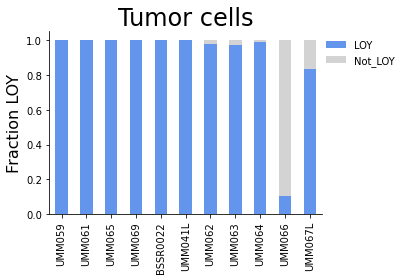

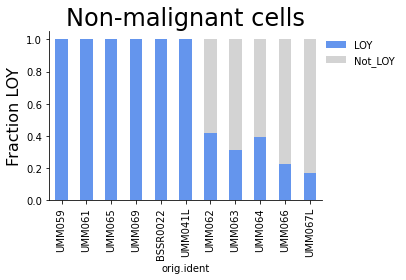

In [39]:
# Figure 5K
Durante_tumor_cells  = uvm_sc_Durante[['orig.ident', 'super_cell' ,'loy_pred' ]].groupby('orig.ident').value_counts()

# plot order: female primary first, then female met, then male primary, male met
order = ['UMM059', 'UMM061', 'UMM065', 'UMM069',  'BSSR0022','UMM041L',  'UMM062', 'UMM063', 'UMM064', 'UMM066', 'UMM067L']
Durante_tumor_cells = uvm_sc_Durante[uvm_sc_Durante.super_cell=='Tumor cells']
Durante_tumor_cells_grouped = (Durante_tumor_cells.groupby('orig.ident')['loy_pred'].value_counts()/Durante_tumor_cells.groupby('orig.ident')['loy_pred'].count()).unstack()
Durante_tumor_cells_grouped.loc[order].plot(kind='bar', stacked='True', color = {'LOY':'cornflowerblue', 'Not_LOY':'lightgrey'})
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Fraction LOY', fontsize=16)
plt.title('Tumor cells', fontsize=24)
plt.xlabel('')
plt.tight_layout()
plt.savefig(workdir + 'Durante_SC_tumor_cells.pdf')

# because there are relatively few, aggregate all non-malignant cells
Durante_nonmalignant_cells = uvm_sc_Durante[uvm_sc_Durante.super_cell!='Tumor cells']
Durante_nonmalignant_cells_grouped = (Durante_nonmalignant_cells.groupby('orig.ident')['loy_pred'].value_counts()/Durante_nonmalignant_cells.groupby('orig.ident')['loy_pred'].count()).unstack()
Durante_nonmalignant_cells_grouped.loc[order].plot(kind='bar', stacked='True', color = {'LOY':'cornflowerblue', 'Not_LOY':'lightgrey'})
plt.gca().spines['right'].set_visible(False)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.0), frameon=False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('Fraction LOY', fontsize=16)
plt.title('Non-malignant cells', fontsize=24)
plt.tight_layout()
plt.savefig(fig_dir + 'Durante_SC_nonmalignant_cells.pdf')

    

<h3> Association of LOX with distant metastasis </h3>

LOX/metastasis Fisher p: (0.20168067226890757, 0.06191222570532917)
46.666666666666664 % of LOX cases metastasized vs 15.0 % of wt cases


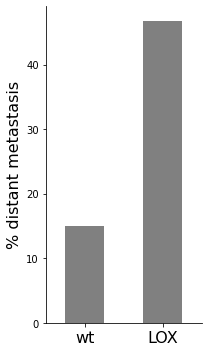

In [40]:
# Female LOX calls
WEX_calls_female = pd.read_excel('Supplementary_tables.xlsx', sheet_name='Supp_Table_2', header=0, index_col=0)

LOX_cases = WEX_calls_female[(WEX_calls_female.Gender=='female') & (WEX_calls_female.X_status=='LOX')].index
wtX_cases = WEX_calls_female[(WEX_calls_female.Gender=='female') & (WEX_calls_female.X_status=='WT')].index

TCGA_sample_info['LOX_status'] = TCGA_sample_info.apply(lambda x: WEX_calls_female.loc[x.name].X_status if x.name in WEX_calls_female.index else np.nan, axis=1)

UVM_clinical['X_status'] = UVM_clinical.apply(lambda x: 'LOX' if (x.name in females and x.name in LOX_cases) else ('wt_female' if x.name in females else 'NA'), axis=1)
UVM_subtypes['X_status'] = UVM_subtypes.apply(lambda x: 'LOX' if (x.name in females and x.name in LOX_cases) else ('wt_female' if x.name in females else 'NA'), axis=1)

# Supplementary Figure 9A
df = UVM_clinical[UVM_clinical.Gender=='Female'].groupby('X_status')['Distant Metastasis'].value_counts().unstack()
met_fisher = fisher_exact(df.loc[['LOX', 'wt_female']])
print('LOX/metastasis Fisher p:', met_fisher)
print(7/15*100, '% of LOX cases metastasized vs', 3/20*100, '% of wt cases' )
df.fraction = df.Yes/(df.Yes+df.No)*100
plt.figure(figsize=(3,5)) 
df.fraction[['wt_female', 'LOX']].plot(kind='bar', color='grey')
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.ylabel('% distant metastasis', fontsize=16)
plt.xlabel('', fontsize=16)
plt.title('')
plt.xticks([0,1], labels=['wt', 'LOX'], rotation = 0, fontsize=16);
plt.tight_layout()
plt.savefig(fig_dir + 'UVM_distant_met_barplot_LOX.pdf')

<h3> CCFs for common driver CNVs</h3>

Mann-Whitney U LOY/6p p=0.96758649952275
Mann-Whitney U LOY/3p p=0.5842032717432648
Mann-Whitney U LOY/8q p=0.6172699158007086


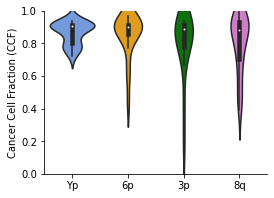

In [41]:
CNV_CCF = pd.read_csv('table.arm.amp_del.all_male.cn_state.filtered.ratio_0_5_amp_del.tsv', sep='\\t', header=0)
UVM_CNV_CCF_males = CNV_CCF[CNV_CCF.case_id.isin(males) & (CNV_CCF.Cohort=='UVM')]

#Yp_CCF = CNV_CCF[(CNV_CCF.arm=='Yp') & (CNV_CCF.cn_state=='del')]
LOYp = UVM_CNV_CCF_males[(UVM_CNV_CCF_males.arm=='Yp') & (UVM_CNV_CCF_males.tcn==0)]

monosomy3p = UVM_CNV_CCF_males[(UVM_CNV_CCF_males.arm=='3p') & (UVM_CNV_CCF_males.tcn==1)]
monosomy3q = UVM_CNV_CCF_males[(UVM_CNV_CCF_males.arm=='3q') & (UVM_CNV_CCF_males.tcn==1)]

gain8q =  UVM_CNV_CCF_males[(UVM_CNV_CCF_males.arm=='8q') & (UVM_CNV_CCF_males.tcn>2)]

gain6p = UVM_CNV_CCF_males[(UVM_CNV_CCF_males.arm=='6p') & (UVM_CNV_CCF_males.tcn>2)]

#include 3p as representative for monosomy 3 in plot as they are virtually the same
df = pd.concat([LOYp, monosomy3p, gain8q, gain6p])
# Remove two cases with very low purity and questionable CFs\n",
#UVM-WC-A888-TP-NB has extremely low purity, 0.358, and discordant purity calls in TCGA (ABSOLUTE 1, FACETs 0.345)\n",
#UVM-YZ-A980-TP-NB has low purity (0.423 here; TCGA FACETs 0.429, ABSOLUTE 0.46 and low CCFs for all events (0.422)\n",
df = df[~df.pair_name.isin(['UVM-WC-A888-TP-NB', 'UVM-YZ-A980-TP-NB'])]


median_CCFs = df.groupby('arm').cf.median().sort_values(ascending=False)
fig, ax = plt.subplots(1,1, figsize = (4, 3))
sns.violinplot(x = 'arm', y = 'cf',  data = df, order = median_CCFs.index, palette = ['cornflowerblue', 'orange', 'green',  'orchid'])
sns.despine()
ax.set_ylim(0,1)
ax.set_ylabel('Cancer Cell Fraction (CCF)')
ax.set_xlabel('')
plt.savefig(fig_dir + 'UVM_CNV_CCFs.pdf')

print('Mann-Whitney U LOY/6p p=' + str(mannwhitneyu(df[df.arm=='Yp'].cf.dropna(), df[df.arm=='6p'].cf.dropna()).pvalue))
print('Mann-Whitney U LOY/3p p=' + str(mannwhitneyu(df[df.arm=='Yp'].cf.dropna(), df[df.arm=='3p'].cf.dropna()).pvalue))
print('Mann-Whitney U LOY/8q p=' + str(mannwhitneyu(df[df.arm=='Yp'].cf.dropna(), df[df.arm=='8q'].cf.dropna()).pvalue))


<h3> Overall chromosomal instability in uveal melanoma </h3>

In [42]:
# association of LOY with overall genomic instability 
# fraction of genome altered and aneuploidy scores (Taylor et al, TCGA Pancan, Table S2)
genome_instability_values = pd.read_excel('1-s2.0-S1535610818301119-mmc2.xlsx', sheet_name=0,header=0,skiprows=1, index_col=0)
genome_instability_values['case_id'] = genome_instability_values.index
genome_instability_values.index = [x[0:12] for x in genome_instability_values.index]
genome_instability_values['tumor_type'] = genome_instability_values.apply(lambda x: TCGA_sample_info.loc[x.name]['type'] if x.name in TCGA_sample_info.index else 'NA', axis=1)

# supplementary tables contain the exact exome sample ID for which LOY was calculated
supp_table_male = pd.read_excel('Supplementary_tables.xlsx', sheet_name = 'Supp_Table_1', header=0, index_col=0)
supp_table_female = pd.read_excel('Supplementary_tables.xlsx', sheet_name = 'Supp_Table_2', header=0, index_col=0)

genome_instability_values['LOY_status'] = genome_instability_values.apply(lambda x: 'NA' if not x.case_id in supp_table_male.case_tcga_sample_id.to_list() else supp_table_male[supp_table_male.case_tcga_sample_id==x.case_id].Y_status[0], axis=1)
genome_instability_values['LOX_status'] = genome_instability_values.apply(lambda x: 'NA' if not x.case_id in supp_table_female.case_tcga_sample_id.to_list() else supp_table_female[supp_table_female.case_tcga_sample_id==x.case_id].X_status[0], axis=1)


In [43]:
# genome instability scores for uveal melanoma
genome_instability_values_UVM = genome_instability_values.loc[TCGA_sample_info[TCGA_sample_info.type=='UVM'].index]


Male: Y_status
LOY        1.0
wt_male    0.0
Name: AS_del_no3, dtype: float64
Male Mann-Whitney U p=0.004159993659900009
Female: X_status
LOX          1.0
wt_female    1.0
Name: AS_del_no3, dtype: float64
Female Mann-Whitney U p=0.8985177977213483


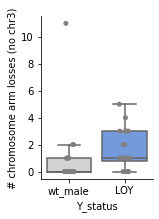

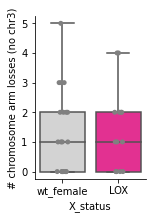

In [44]:
# Is association of LOY/LOX with distant metastasis simply due to overall increased genomic instability? 

UVM_subtypes['Aneuploidy_score'] = UVM_subtypes.apply(lambda x: genome_instability_values.loc[x.name]['AneuploidyScore(AS)'], axis=1) 
UVM_subtypes['AS_del'] = UVM_subtypes.apply(lambda x: genome_instability_values.loc[x.name]['AS_del'], axis=1) 

UVM_subtypes['Distant Metastasis'] = UVM_subtypes.apply(lambda x: UVM_clinical.loc[x.name]['Distant Metastasis'], axis=1)

# subtract 3p and 3q deletions since they are not random. Copy state is encoded by -1 (loss), 0 (no change), 1 (gain)
UVM_subtypes['AS_del_no3'] = UVM_subtypes.apply(lambda x: int(x.AS_del) + min(genome_instability_values_UVM.loc[x.name]['3p'], 0) + min(genome_instability_values_UVM.loc[x.name]['3q'], 0), axis =1 )

# Supplementary Figure 7C
fig, ax = plt.subplots(1, 1, figsize=(2,3 ))
sns.stripplot(x = 'Y_status', y = 'AS_del_no3', data=UVM_subtypes[UVM_subtypes.Gender=='Male'], order = ['wt_male', 'LOY'], color='grey')
sns.boxplot(x = 'Y_status', y = 'AS_del_no3', data=UVM_subtypes[UVM_subtypes.Gender=='Male'], order = ['wt_male', 'LOY'], palette = palette,  fliersize = 0)
ax.set_ylabel('# chromosome arm losses (no chr3)')
sns.despine()
plt.savefig(fig_dir + 'LOY_WT_arm_loss_distribution.pdf')

print ('Male:', UVM_subtypes[UVM_subtypes.Gender=='Male'].groupby([ 'Y_status'])['AS_del_no3'].median())
print('Male Mann-Whitney U p=' + str(mannwhitneyu(UVM_subtypes[(UVM_subtypes['Y_status']=='LOY') & (UVM_subtypes.Gender=='Male')]['AS_del_no3'].dropna(), UVM_subtypes[(UVM_subtypes['Y_status']=='wt_male') & (UVM_subtypes.Gender=='Male')]['AS_del_no3'].dropna()).pvalue))

# Supplementary Figure 9B
fig, ax = plt.subplots(1, 1, figsize=(2,3 ))
sns.boxplot(x = 'X_status', y = 'AS_del_no3', data=UVM_subtypes[UVM_subtypes.Gender=='Female'], palette = palette, fliersize = 0)
sns.stripplot(x = 'X_status', y = 'AS_del_no3', data=UVM_subtypes[UVM_subtypes.Gender=='Female'], color='grey')
ax.set_ylabel('# chromosome arm losses (no chr3)')
sns.despine()

plt.savefig(fig_dir + 'LOX_WT_arm_loss_distribution.pdf')

print ('Female:', UVM_subtypes[UVM_subtypes.Gender=='Female'].groupby([ 'X_status'])['AS_del_no3'].median())
print('Female Mann-Whitney U p=' + str(mannwhitneyu(UVM_subtypes[(UVM_subtypes['X_status']=='LOX') & (UVM_subtypes.Gender=='Female')]['AS_del_no3'].dropna(), UVM_subtypes[(UVM_subtypes['X_status']=='wt_female') & (UVM_subtypes.Gender=='Female')]['AS_del_no3'].dropna()).pvalue))
